# Elo Merchant Category Recommendation
[Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation)

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

## 1. kernel by Peter Hurford
[You're Going to Want More Categories](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737)

In [1]:
import os
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
import warnings
import datetime
warnings.filterwarnings("ignore")
print(os.listdir("input"))

['Data_Dictionary.xlsx', 'historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

201,917 observations and 6 features in train set.
123,623 observations and 5 features in test set.


In [3]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056


In [4]:
print('Feature_1: ' + str(df_train['feature_1'].min()) + '-' + str(df_train['feature_1'].max()))
print('Feature_2: ' + str(df_train['feature_2'].min()) + '-' + str(df_train['feature_2'].max()))
print('Feature_3: ' + str(df_train['feature_3'].min()) + '-' + str(df_train['feature_3'].max()))

Feature_1: 1-5
Feature_2: 1-3
Feature_3: 0-1


In [5]:
df_train["month"] = df_train["first_active_month"].dt.month
df_test["month"] = df_test["first_active_month"].dt.month
df_train["year"] = df_train["first_active_month"].dt.year
df_test["year"] = df_test["first_active_month"].dt.year
df_train['elapsed_time'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days
df_test['elapsed_time'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,549


In [6]:
df_train = pd.get_dummies(df_train, columns=['feature_1', 'feature_2'])
df_test = pd.get_dummies(df_test, columns=['feature_1', 'feature_2'])
df_train[:3]

,first_active_month,card_id,feature_3,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-06-01,C_ID_92a2005557,1,-0.820283,6,2017,245,0,0,0,0,1,0,1,0
1,2017-01-01,C_ID_3d0044924f,0,0.392913,1,2017,396,0,0,0,1,0,1,0,0
2,2016-08-01,C_ID_d639edf6cd,0,0.688056,8,2016,549,0,1,0,0,0,0,1,0


In [7]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
pd.set_option('float_format', '{:,.2f}'.format)
df_hist_trans.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,"29,112,361.00","29,112,361.00","29,112,361.00","29,112,361.00","29,112,361.00","26,459,497.00","29,112,361.00","29,112,361.00"
mean,129.33,0.65,481.01,-4.49,0.04,2.19,10.57,26.85
std,104.26,2.80,249.38,3.59,"1,123.52",1.53,6.37,9.69
min,-1.00,-1.00,-1.00,-13.00,-0.75,1.00,-1.00,-1.00
25%,53.00,0.00,307.00,-7.00,-0.72,1.00,9.00,19.00
50%,90.00,0.00,454.00,-4.00,-0.69,1.00,9.00,29.00
75%,212.00,1.00,705.00,-2.00,-0.60,3.00,16.00,34.00
max,347.00,999.00,891.00,0.00,"6,010,603.97",5.00,24.00,41.00


In [9]:
df_hist_trans = pd.get_dummies(df_hist_trans, columns=['category_2', 'category_3'])
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'Y': 1, 'N': 0})
df_hist_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.70,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.73,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.72,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0


In [10]:
def aggregate_transactions(trans, prefix):  
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9

    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [11]:
merch_hist = aggregate_transactions(df_hist_trans, prefix='hist_')
del df_hist_trans
gc.collect()
df_train = pd.merge(df_train, merch_hist, on='card_id',how='left')
df_test = pd.merge(df_test, merch_hist, on='card_id',how='left')
del merch_hist
gc.collect()
df_train[:3]

,first_active_month,card_id,feature_3,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,...,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,2017-06-01,C_ID_92a2005557,1,-0.82,6,2017,245,0,0,0,...,-0.74,0.21,4,0.02,1,0,0.12,"20,977,987.00",-8,0
1,2017-01-01,C_ID_3d0044924f,0,0.39,1,2017,396,0,0,0,...,-0.74,0.38,543,1.55,10,-1,1.51,"33,717,687.00",-12,0
2,2016-08-01,C_ID_d639edf6cd,0,0.69,8,2016,549,0,1,0,...,-0.73,0.09,0,0.00,0,0,0.00,"35,635,623.00",-13,0


In [12]:
df_train.to_csv('output/historical_transactions_aggregated_train.csv')
df_test.to_csv('output/historical_transactions_aggregated_test.csv')

In [ ]:
df_train = pd.read_csv('output/historical_transactions_aggregated_train.csv')
df_test = pd.read_csv('output/historical_transactions_aggregated_test.csv')

In [13]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.56,2018-03-11 14:57:36,1.00,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.57,2018-03-19 18:53:37,1.00,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.55,2018-04-26 14:08:44,1.00,9,14


In [14]:
df_new_trans = pd.get_dummies(df_new_trans, columns=['category_2', 'category_3'])
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'Y': 1, 'N': 0})
df_new_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.56,2018-03-11 14:57:36,9,19,1,0,0,0,0,0,1,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.57,2018-03-19 18:53:37,9,19,1,0,0,0,0,0,1,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.55,2018-04-26 14:08:44,9,14,1,0,0,0,0,0,1,0


In [15]:
merch_new = aggregate_transactions(df_new_trans, prefix='new_')
del df_new_trans
gc.collect()
df_train = pd.merge(df_train, merch_new, on='card_id', how='left')
df_test = pd.merge(df_test, merch_new, on='card_id', how='left')
del merch_new
gc.collect()
df_train[:3]

,first_active_month,card_id,feature_3,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,...,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,2017-06-01,C_ID_92a2005557,1,-0.82,6,2017,245,0,0,0,...,-0.72,0.14,0.00,0.00,0.00,0.00,0.00,"4,742,309.00",1.00,2.00
1,2017-01-01,C_ID_3d0044924f,0,0.39,1,2017,396,0,0,0,...,-0.74,0.01,6.00,1.00,1.00,1.00,0.00,"4,887,632.00",1.00,2.00
2,2016-08-01,C_ID_d639edf6cd,0,0.69,8,2016,549,0,1,0,...,-0.70,nan,0.00,0.00,0.00,0.00,nan,0.00,2.00,2.00


In [16]:
target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)
df_train[features][:3]

,feature_3,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,...,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,1,6,2017,245,0,0,0,0,1,0,...,-0.72,0.14,0.00,0.00,0.00,0.00,0.00,"4,742,309.00",1.00,2.00
1,0,1,2017,396,0,0,0,1,0,1,...,-0.74,0.01,6.00,1.00,1.00,1.00,0.00,"4,887,632.00",1.00,2.00
2,0,8,2016,549,0,1,0,0,0,0,...,-0.70,nan,0.00,0.00,0.00,0.00,nan,0.00,2.00,2.00


In [17]:
print('Total number of lines of train data: ' + "{:,}".format(df_train.shape[0]))
print('Total number of lines of test data: ' + "{:,}".format(df_test.shape[0]))

Total number of lines of train data: 201,917
Total number of lines of test data: 123,623


In [18]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.75147	valid_1's rmse: 3.81823
[200]	training's rmse: 3.69496	valid_1's rmse: 3.78503
[300]	training's rmse: 3.65231	valid_1's rmse: 3.7654
[400]	training's rmse: 3.61679	valid_1's rmse: 3.75126
[500]	training's rmse: 3.58676	valid_1's rmse: 3.74122
[600]	training's rmse: 3.56052	valid_1's rmse: 3.73348
[700]	training's rmse: 3.53924	valid_1's rmse: 3.7287
[800]	training's rmse: 3.51838	valid_1's rmse: 3.72433
[900]	training's rmse: 3.50043	valid_1's rmse: 3.72129
[1000]	training's rmse: 3.48334	valid_1's rmse: 3.71835
[1100]	training's rmse: 3.46742	valid_1's rmse: 3.71616
[1200]	training's rmse: 3.45332	valid_1's rmse: 3.71452
[1300]	training's rmse: 3.4399	valid_1's rmse: 3.71248
[1400]	training's rmse: 3.42768	valid_1's rmse: 3.7113
[1500]	training's rmse: 3.41651	valid_1's rmse: 3.71049
[1600]	training's rmse: 3.40581	valid_1's rmse: 3.70992
[1700]	training's rmse: 3.39492	valid_1's rms

In [19]:
from sklearn.metrics import mean_squared_error
val_score = np.sqrt(mean_squared_error(target, oof))
val_score

3.689933224026299

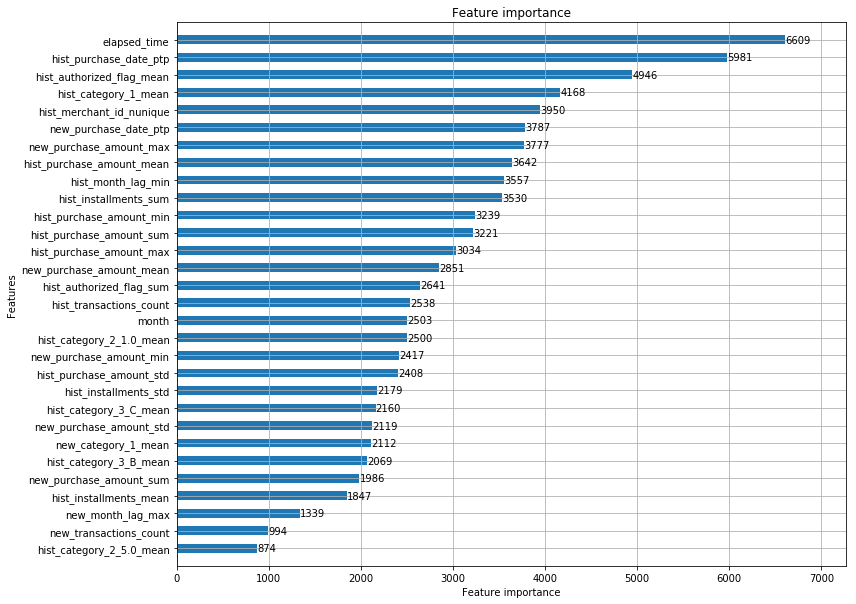

In [20]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(clf, max_num_features=30, height=0.5, ax=ax, title='Feature importance', xlabel='Feature importance', ylabel='Features')
plt.show()

In [21]:
sorted(list(zip(clf.feature_importance(), features)), reverse=True)

[(6609, 'elapsed_time'),
 (5981, 'hist_purchase_date_ptp'),
 (4946, 'hist_authorized_flag_mean'),
 (4168, 'hist_category_1_mean'),
 (3950, 'hist_merchant_id_nunique'),
 (3787, 'new_purchase_date_ptp'),
 (3777, 'new_purchase_amount_max'),
 (3642, 'hist_purchase_amount_mean'),
 (3557, 'hist_month_lag_min'),
 (3530, 'hist_installments_sum'),
 (3239, 'hist_purchase_amount_min'),
 (3221, 'hist_purchase_amount_sum'),
 (3034, 'hist_purchase_amount_max'),
 (2851, 'new_purchase_amount_mean'),
 (2641, 'hist_authorized_flag_sum'),
 (2538, 'hist_transactions_count'),
 (2503, 'month'),
 (2500, 'hist_category_2_1.0_mean'),
 (2417, 'new_purchase_amount_min'),
 (2408, 'hist_purchase_amount_std'),
 (2179, 'hist_installments_std'),
 (2160, 'hist_category_3_C_mean'),
 (2119, 'new_purchase_amount_std'),
 (2112, 'new_category_1_mean'),
 (2069, 'hist_category_3_B_mean'),
 (1986, 'new_purchase_amount_sum'),
 (1847, 'hist_installments_mean'),
 (1339, 'new_month_lag_max'),
 (994, 'new_transactions_count'),
 (8

In [22]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/sub_val_{}.csv".format(val_score), index=False)